# Calling the Instance Segmentation CV model to detect cans

In [1]:
import sys
sys.version

'3.8.1 (default, Jan  8 2020, 22:29:32) \n[GCC 7.3.0]'

In [2]:
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
import requests
import json
import datetime
import matplotlib.pyplot as plt 
import uuid
from IPython.display import display_javascript, display_html, display
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np
import os

In [3]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


In [4]:
service = Webservice(workspace=ws, name='automl-instanceseg-cansdetection')
#print(service.scoring_uri)
#print(service.swagger_uri)

In [5]:
primary, secondary = service.get_keys()

In [6]:
# URL for the web service
scoring_uri = service.scoring_uri
# If the service is authenticated, set the key or token
key = primary

In [92]:
#sample_image = "tests/test1.jpg"
#sample_image = "tests/test2.jpg"
sample_image = "tests/test3.jpg"
#sample_image = "tests/test5.jpg"

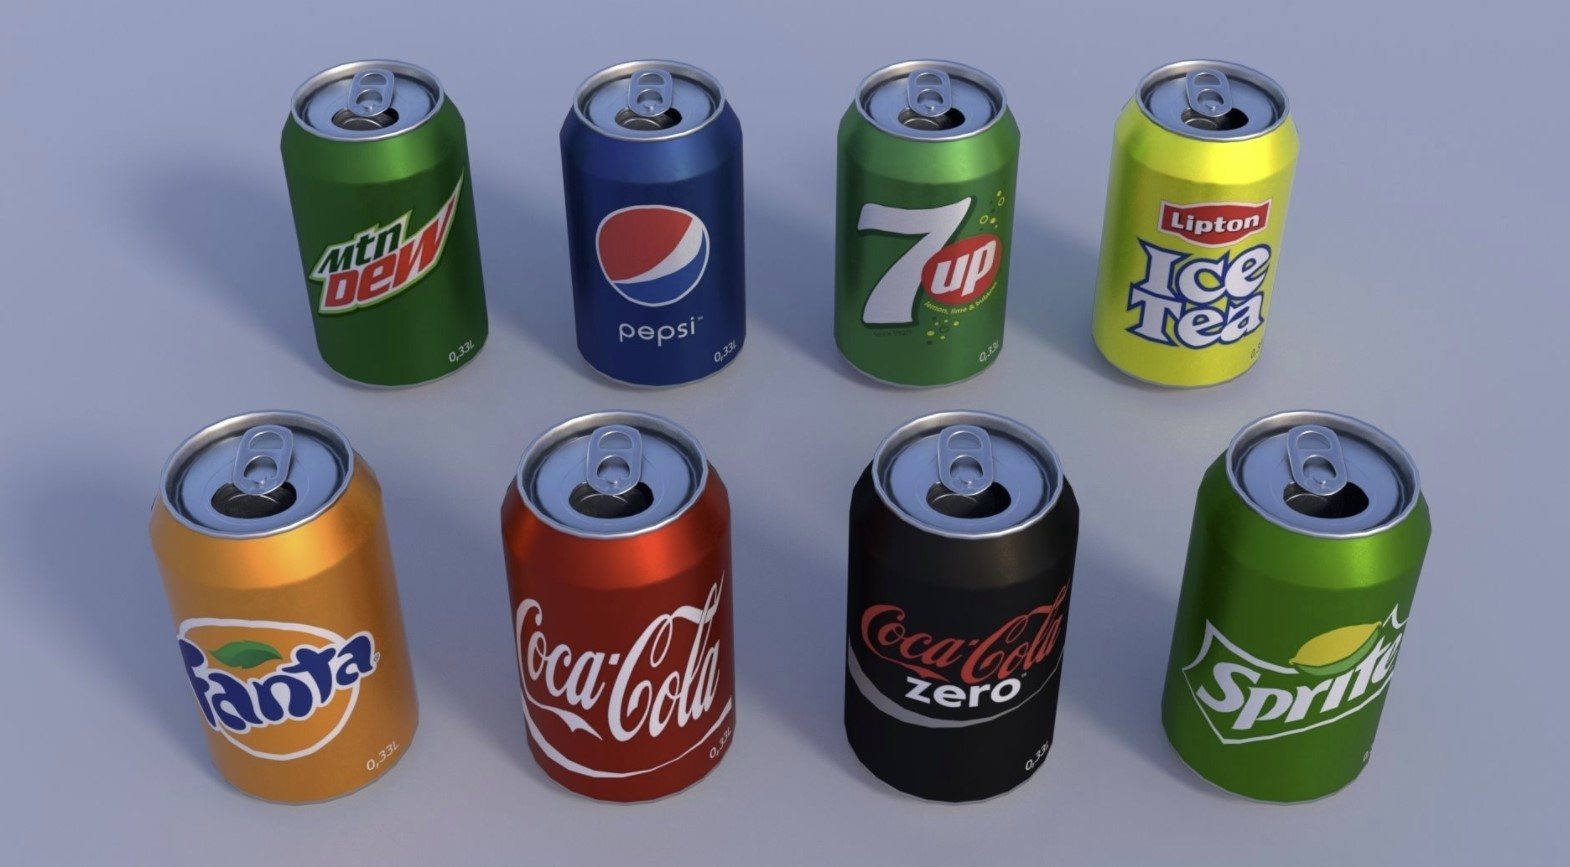

In [93]:
from IPython.display import Image
Image(filename=sample_image) 

In [94]:
t1 = datetime.datetime.now()

data = open(sample_image, "rb").read()
headers = {"Content-Type": "application/octet-stream"}
headers["Authorization"] = f"Bearer {key}"
resp = requests.post(scoring_uri, data, headers=headers)

t2 = datetime.datetime.now()
print("Time:", t2 - t1)

Time: 0:00:00.710038


In [95]:
class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

In [96]:
RenderJSON(resp.text)

In [97]:
min_confscore = 0.8

In [98]:
detections = json.loads(resp.text)

nlabel = 1
for detect in detections["boxes"]:
    if detect["score"] > min_confscore: # Min Value
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]
        print("\033[1;31;34m", nlabel, label, 'with confidence =', conf_score)
        #print("Polygon:", polygon, '\n')
        nlabel+=1

print("\nResults:", nlabel-1, "cans were detected.")

 1 can with confidence = 0.9992774128913879
 2 can with confidence = 0.9987766146659851
 3 can with confidence = 0.9986718893051147
 4 can with confidence = 0.9985681772232056
 5 can with confidence = 0.9985321760177612
 6 can with confidence = 0.9955008625984192
 7 can with confidence = 0.9907370209693909
 8 can with confidence = 0.973227858543396

Results: 8 cans were detected.


In [99]:
round_values = 4
color_dots = 'blue'
color_back = 'orange'
color_rect = 'lime'
color_text = 'blue'
rect_line_width = 5
marker_size = 10
font_size = 15

Instance Segmentation Custom vision model predictions:

 1 Object detected: can with confidence = 0.9993 | region: 502.9825 421.3429 231.2558 373.1132
 2 Object detected: can with confidence = 0.9988 | region: 1096.7359 69.495 194.4607 319.3141
 3 Object detected: can with confidence = 0.9987 | region: 832.8336 66.6807 182.6933 321.4725
 4 Object detected: can with confidence = 0.9986 | region: 281.0542 67.08 197.956 319.9494
 5 Object detected: can with confidence = 0.9985 | region: 561.4752 67.9527 181.8443 319.0691
 6 Object detected: can with confidence = 0.9955 | region: 1155.7399 422.5866 266.7465 367.1977
 7 Object detected: can with confidence = 0.9907 | region: 156.525 415.9773 263.9989 375.1132
 8 Object detected: can with confidence = 0.9732 | region: 834.7683 404.014 231.3668 394.7497

 Total of detected objects = 8


<Figure size 1296x864 with 0 Axes>

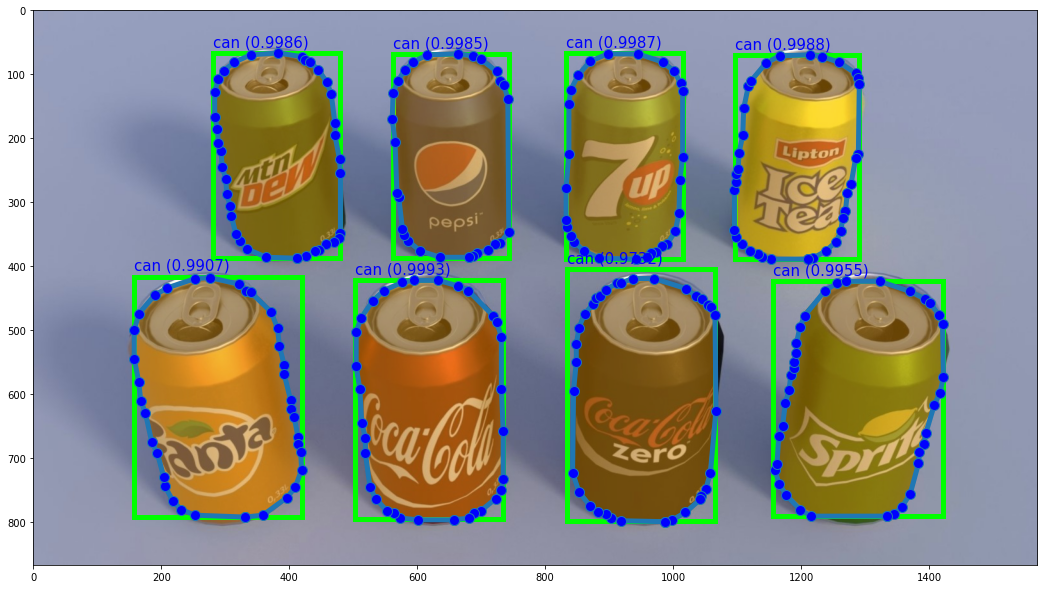

In [101]:
%matplotlib inline
from IPython.display import display_javascript, display_html, display
from matplotlib.lines import Line2D
from PIL import Image

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(18, 17)) # Dimensions
ax.imshow(img_np)

numberobjects = 1

print("Instance Segmentation Custom vision model predictions:\n")

detections = json.loads(resp.text)
for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    polygon = detect["polygon"]
    conf_score = detect["score"]
    
    if conf_score > min_confscore:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        
        print("\033[1;31;34m", numberobjects, 'Object detected:', detect["label"], "with confidence =", 
              round(conf_score, round_values),
              "| region:", round(topleft_x, round_values), round(topleft_y, round_values), round(width, round_values),
              round(height, round_values))
        
        numberobjects+=1
        
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=rect_line_width,
            edgecolor=color_rect,
            facecolor="none",
        )

        ax.add_patch(rect)
        labelmsg = label + ' (' + str(round(conf_score, round_values)) + ')'
        plt.text(topleft_x, topleft_y - 10, labelmsg, color=color_text, fontsize=font_size)

        polygon_np = np.array(polygon[0])
        polygon_np = polygon_np.reshape(-1, 2)
        polygon_np[:, 0] *= x
        polygon_np[:, 1] *= y
        poly = patches.Polygon(polygon_np, True, facecolor=color_back, alpha=0.4)
        ax.add_patch(poly)
        
        poly_line = Line2D(
            polygon_np[:, 0],
            polygon_np[:, 1],
            linewidth=5,
            marker="o",
            markersize=marker_size,
            markerfacecolor=color_dots,
        )
        ax.add_line(poly_line)
 
    totalobjects = numberobjects - 1

outputfilename = os.path.splitext(sample_image)[0] + '_has_' + str(totalobjects) + '_objects.jpg'
fig.savefig(outputfilename, dpi=150) #Saving image

print("\n \033[1;31;91mTotal of detected objects =", totalobjects)
plt.show()